In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import date
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import pickle
import plotly.graph_objects as go

In [5]:
START = "2010-01-01"
END = date.today().strftime("%Y-%m-%d")

In [6]:
def load_data(ticker):
    data = yf.download(ticker,START,END)
    data.reset_index(inplace=True)
    return data

In [7]:
df = load_data('AAPL')

[*********************100%***********************]  1 of 1 completed


In [8]:
df = df.drop('Adj Close',axis=1)


In [9]:
df_Close = df[['Close','Date']]

In [10]:
df_Close.set_index('Date')

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
...,...
2021-05-14,127.449997
2021-05-17,126.269997
2021-05-18,124.849998


In [11]:
df_open = df[['Open','Date']]

In [12]:
#Filter Close column insted of deleting it
df_open = df_open.drop('Date',axis=1)

In [13]:
df_open.shape

(2865, 1)

In [14]:
#Save values in an array
df_open

,Open
0,7.622500
1,7.664286
2,7.656429
3,7.562500
4,7.510714
...,...
2860,126.250000
2861,126.820000
2862,126.559998
2863,123.160004


In [15]:
traindata_size = math.ceil(len(df_open)*.8)
testdata_size = len(df_open) - traindata_size

In [16]:
traindata_size

2292

In [17]:
testdata_size

573

In [18]:
train = df_open[0:traindata_size]
print(len(train))

2292


In [19]:
sc = MinMaxScaler(feature_range = (0,1))
scaled_train = sc.fit_transform(train)

In [20]:
X_train = []
y_train = []

for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-60:i, 0])
    y_train.append(scaled_train[i, 0])
    

X_train = np.array(X_train)
y_train = np.array(y_train)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [42]:
model = keras.Sequential()

model.add(layers.LSTM(units= 50, return_sequences = True, input_shape= (X_train.shape[1],1)))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units= 50, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units= 50, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units= 25))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 1))

In [43]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [44]:
model.fit(X_train,y_train, batch_size = 1, epochs = 5)

Epoch 1/5
2232/2232 [==============================] - 73s 30ms/step - loss: 0.0060
Epoch 2/5
2232/2232 [==============================] - 72s 32ms/step - loss: 0.0030
Epoch 3/5
2232/2232 [==============================] - 73s 33ms/step - loss: 0.0025
Epoch 4/5
2232/2232 [==============================] - 74s 33ms/step - loss: 0.0023
Epoch 5/5
2232/2232 [==============================] - 74s 33ms/step - loss: 0.0020


In [45]:
test = df_open[traindata_size - 60:]
print(len(test))

633


In [46]:
scaled_test = sc.fit_transform(test)

In [47]:
X_test = []
y_test = df_open[traindata_size:]
for i in range(60,len(scaled_test)):
    X_test.append(scaled_test[i-60:i, 0])

X_test = np.array(X_test)

In [48]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [49]:
pred = model.predict(X_test)
predictions = sc.inverse_transform(pred)

In [50]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

Open    0.650682
dtype: float64

<ipython-input-51-d9b4e015319a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


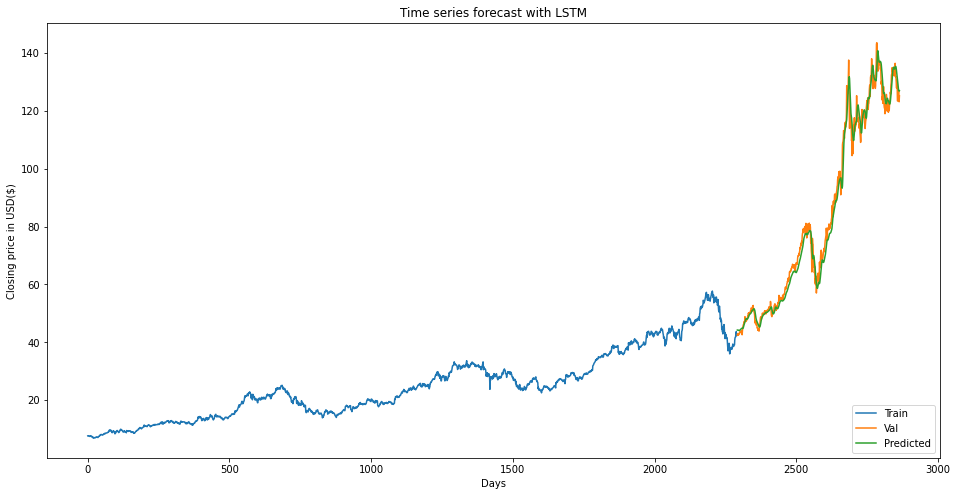

In [51]:
train = df_open[:traindata_size]
valid = df_open[traindata_size:]
valid['predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title("Time series forecast with LSTM")
plt.xlabel("Days")
plt.ylabel("Closing price in USD($)")
plt.plot(train['Open'])
plt.plot(valid[['Open','predictions']])
plt.legend(['Train','Val','Predicted'],loc='lower right')
plt.show()

In [52]:
predictions[570]

array([126.94306], dtype=float32)

In [53]:
valid

,Open,predictions
2292,42.525002,44.207008
2293,42.847500,44.243092
2294,42.427502,44.233776
2295,42.812500,44.190243
2296,42.427502,44.148342
...,...,...
2860,126.250000,127.908463
2861,126.820000,127.146690
2862,126.559998,126.943062
2863,123.160004,127.089142


In [55]:
model.save('LSTM2.h5')
